In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import glob

from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve




/home/frank/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
class CONFIG:
    seq_len = 32
    num_seq = 50
    num_feat = 4
    num_class = 2  # Number of GRU layers
    learning_rate = 0.0001
    num_epochs = 100
    batch_size = 32
    # data_path = "D:\PythonProjs\CLARAi\Data_train_sensory\*.csv"
    # label_path = "D:\PythonProjs\CLARAi\Label_train\*.csv"
    # test_data_path = "D:\PythonProjs\CLARAi\Data_test_sensory\data16.csv"
    # test_label_path = "D:\PythonProjs\CLARAi\Label_test\label16.csv"

    data_path = "/home/frank/Documents/CLARAi/Data_train_sensory/*.csv"
    label_path = "/home/frank/Documents/CLARAi/Label_train/*.csv"
    test_data_path = "/home/frank/Documents/CLARAi/Data_test_sensory/data10.csv"
    test_label_path = "/home/frank/Documents/CLARAi/Label_test/label10.csv"

In [4]:
def data_gen(data_path, label_path):
    final_data_df = pd.read_csv(data_path)
    final_label_df = pd.read_csv(label_path)

    train_labels_flat = final_label_df.values.flatten()
    
    # Compute class weights (inverse of class frequencies)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_flat), y=train_labels_flat)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # Parameters
    sequence_length = CONFIG.seq_len  # Length of each subsequence
    num_subsequences = CONFIG.num_seq  # Number of subsequences to extract

    # Get possible starting indices, ensuring there's enough space for a full subsequence
    possible_starts = np.arange(0, len(final_data_df) - sequence_length)
    np.random.shuffle(possible_starts)

    # Select the first `num_subsequences` starting indices
    selected_starts = possible_starts[:num_subsequences]

    # Create a list to hold the subsequences
    subsequences = [final_data_df.iloc[start:start + sequence_length].values for start in selected_starts]
    sublabels = [final_label_df.iloc[start + sequence_length-1].values for start in selected_starts]

    # Convert subsequences list to a NumPy array
    subsequences_array = np.array(subsequences)
    sublabels_array = np.array(sublabels)

    # subsequences_array will have shape (num_subsequences, sequence_length, num_channels)
    # print(subsequences_array.shape)  # Should print (100, 100, 36)
    # print(sublabels_array.shape)

    return torch.from_numpy(subsequences_array), torch.from_numpy(sublabels_array), class_weights


In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_chunks, labels, transform=None):
        """
        Args:
            data_chunks (numpy.ndarray): Array of shape (num_samples, 128, 36)
            labels (numpy.ndarray): Array of shape (num_samples,)
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_chunks = data_chunks
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data_chunks)

    def __getitem__(self, idx):
        sample = self.data_chunks[idx]
        label = self.labels[idx]
        
        # Add channel dimension (1 for grayscale)
        sample = np.expand_dims(sample, axis=0)  # Shape: (1, 128, 36)
        
        if self.transform:
            sample = self.transform(sample)
        else:
            # Convert to tensor
            sample = torch.tensor(sample, dtype=torch.float32)
        
        label = torch.tensor(label, dtype=torch.long)
        
        return sample, label

In [7]:
# Example data
# Replace these with your actual data
data_path = glob.glob(CONFIG.data_path)  # Modify with your directory path
label_path = glob.glob(CONFIG.label_path)

# data_path = glob.glob("/home/frank/Documents/CLARAi/Data/*.csv")  # Modify with your directory path
# label_path = glob.glob("/home/frank/Documents/CLARAi/Label/*.csv")

# data_path = glob.glob("/Users/xiaosuhu/Documents/Python/CLARAi/Data/*.csv")  # Modify with your directory path
# label_path = glob.glob("/Users/xiaosuhu/Documents/Python/CLARAi/Data/*.csv")

# data_path = glob.glob("/kaggle/input/clarai/CLARAi/Data/*.csv")  # Modify with your directory path
# label_path = glob.glob("/kaggle/input/clarai/CLARAi/Label/*.csv")

# Sort the lists
data_path = sorted(data_path)
label_path = sorted(label_path)

neuroimaging_data = torch.empty(0,CONFIG.seq_len,CONFIG.num_feat)
labels = torch.empty(0,1)
class_weights = torch.Tensor([0., 0.])

for datapath, labelpath in zip(data_path, label_path):
    print(f'datapath: {datapath}')
    print(f'labelpath: {labelpath}')    
    data, label, weight = data_gen(datapath, labelpath)
    print(f'Data shape: {data.shape}, Label shape: {label.shape}, Weight shape: {weight.shape}')
    neuroimaging_data= torch.cat([neuroimaging_data, data])
    labels = torch.cat([labels, label])
    class_weights += weight

normalized_weights = class_weights / class_weights.sum()

# Split into training and validation
split = int(0.8 * neuroimaging_data.shape[0])
train_data, val_data = neuroimaging_data[:split], neuroimaging_data[split:]
train_labels, val_labels = labels[:split], labels[split:]

# Create datasets
train_dataset = CustomDataset(train_data, train_labels)
val_dataset = CustomDataset(val_data, val_labels)

# Create dataloaders
batch_size = CONFIG.batch_size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

datapath: /home/frank/Documents/CLARAi/Data_train_sensory/data1.csv
labelpath: /home/frank/Documents/CLARAi/Label_train/label1.csv
Data shape: torch.Size([50, 32, 4]), Label shape: torch.Size([50, 1]), Weight shape: torch.Size([2])
datapath: /home/frank/Documents/CLARAi/Data_train_sensory/data11.csv
labelpath: /home/frank/Documents/CLARAi/Label_train/label11.csv
Data shape: torch.Size([50, 32, 4]), Label shape: torch.Size([50, 1]), Weight shape: torch.Size([2])
datapath: /home/frank/Documents/CLARAi/Data_train_sensory/data12.csv
labelpath: /home/frank/Documents/CLARAi/Label_train/label12.csv
Data shape: torch.Size([50, 32, 4]), Label shape: torch.Size([50, 1]), Weight shape: torch.Size([2])
datapath: /home/frank/Documents/CLARAi/Data_train_sensory/data13.csv
labelpath: /home/frank/Documents/CLARAi/Label_train/label13.csv
Data shape: torch.Size([50, 32, 4]), Label shape: torch.Size([50, 1]), Weight shape: torch.Size([2])
datapath: /home/frank/Documents/CLARAi/Data_train_sensory/data17.c

In [8]:
neuroimaging_data.shape

torch.Size([650, 32, 4])

In [9]:
# Choose a ResNet architecture
resnet = models.resnet18(weights=None)

# Modify the first convolutional layer to accept single-channel input
# Original: nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

# If your number of classes differs from the default (1000 for ImageNet), modify the final layer
num_classes = CONFIG.num_class  # Replace with your number of classes
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

resnet = resnet.to(device)

# Convert the class weights to a tensor and move to the appropriate device
class_weights = class_weights.to(device)

# Use BCEWithLogitsLoss, which combines sigmoid activation and binary cross-entropy loss
criterion = nn.CrossEntropyLoss(weight=class_weights)  # pos_weight applies only to class 1

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer and scheduler remain the same
optimizer = optim.Adam(resnet.parameters(), lr=CONFIG.learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)


In [10]:
num_epochs = CONFIG.num_epochs

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.squeeze(1).to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total
    
    # Validation
    resnet.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.squeeze(1).to(device)
            
            outputs = resnet(val_inputs)
            loss = criterion(outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (predicted == val_labels).sum().item()
    
    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc = 100 * val_correct / val_total
    
    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
          f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%')


/tmp/ipykernel_456592/1687484282.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long)


Epoch 1/100: Train Loss: 0.7889, Train Acc: 56.73%, Val Loss: 0.8972, Val Acc: 43.08%
Epoch 2/100: Train Loss: 0.6443, Train Acc: 62.12%, Val Loss: 1.1945, Val Acc: 47.69%
Epoch 3/100: Train Loss: 0.6248, Train Acc: 63.85%, Val Loss: 1.2102, Val Acc: 56.92%
Epoch 4/100: Train Loss: 0.6359, Train Acc: 72.69%, Val Loss: 1.8561, Val Acc: 68.46%
Epoch 5/100: Train Loss: 0.5743, Train Acc: 67.88%, Val Loss: 1.1773, Val Acc: 56.92%
Epoch 6/100: Train Loss: 0.5598, Train Acc: 69.04%, Val Loss: 1.1968, Val Acc: 52.31%
Epoch 7/100: Train Loss: 0.5866, Train Acc: 69.23%, Val Loss: 1.8680, Val Acc: 63.85%
Epoch 8/100: Train Loss: 0.5157, Train Acc: 72.50%, Val Loss: 1.4752, Val Acc: 60.77%
Epoch 9/100: Train Loss: 0.5448, Train Acc: 73.85%, Val Loss: 2.0936, Val Acc: 66.92%
Epoch 10/100: Train Loss: 0.5680, Train Acc: 70.77%, Val Loss: 1.8213, Val Acc: 70.00%
Epoch 11/100: Train Loss: 0.5526, Train Acc: 70.38%, Val Loss: 1.7712, Val Acc: 66.92%
Epoch 12/100: Train Loss: 0.5074, Train Acc: 69.04%,

In [13]:
# Test data load
data_test = pd.read_csv(CONFIG.test_data_path)
label_test = pd.read_csv(CONFIG.test_label_path)

data_test= data_test.to_numpy()
label_test = label_test.to_numpy()

# Create a sliding window view of the data to get overlapping sequences
def sliding_window(data, window_size):
    return np.lib.stride_tricks.sliding_window_view(data, (window_size, data.shape[1]))[:, 0, :]

# Apply the sliding window to the test data
overlapping_data = sliding_window(data_test, CONFIG.seq_len)  # Shape: (N-sequence_length+1, 128, 36)

# Convert to PyTorch tensor
test_sequences = torch.tensor(overlapping_data, dtype=torch.float32)

# Now handle the labels (taking the last label of each sequence)
true_labels = label_test[CONFIG.seq_len - 1:]  # Shape: (N-sequence_length+1,)

test_dataset = CustomDataset(test_sequences, true_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [11]:
test_sequences.shape, true_labels.shape

(torch.Size([1087, 32, 4]), (1087, 1))

In [12]:
"""resnet.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.squeeze(1).to(device)
        
        outputs = resnet(test_inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (predicted == test_labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f'Test Accuracy: {test_acc:.2f}%')"""

"resnet.eval()\ntest_correct = 0\ntest_total = 0\n\nwith torch.no_grad():\n    for test_inputs, test_labels in test_loader:\n        test_inputs = test_inputs.to(device)\n        test_labels = test_labels.squeeze(1).to(device)\n        \n        outputs = resnet(test_inputs)\n        _, predicted = torch.max(outputs.data, 1)\n        test_total += test_labels.size(0)\n        test_correct += (predicted == test_labels).sum().item()\n\ntest_acc = 100 * test_correct / test_total\nprint(f'Test Accuracy: {test_acc:.2f}%')"

Test Accuracy: 68.65%


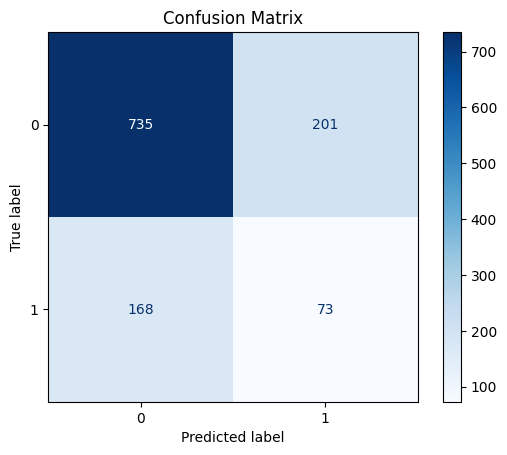

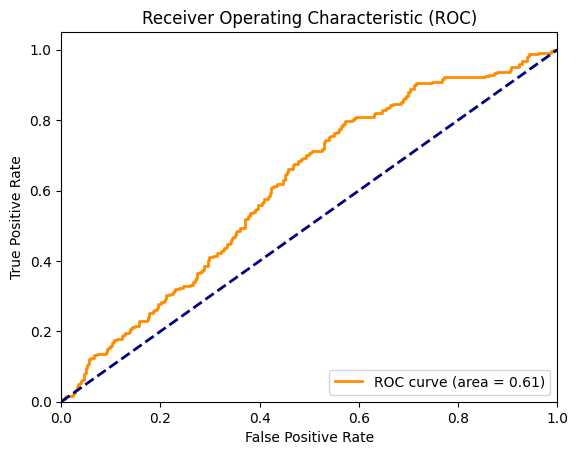

In [14]:
# Set the model to evaluation mode
resnet.eval()

all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.squeeze(1).to(device)
        
        outputs = resnet(test_inputs)
        
        # For predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Save predictions and labels for confusion matrix
        all_labels.extend(test_labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
        # Save probabilities for ROC AUC
        probs = F.softmax(outputs, dim=1)[:, 1]  # Get probability for class 1
        all_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

# Calculate Test Accuracy
test_correct = (all_predictions == all_labels).sum()
test_total = all_labels.size
test_acc = 100 * test_correct / test_total
print(f'Test Accuracy: {test_acc:.2f}%')

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Generate ROC AUC Plot
if len(np.unique(all_labels)) == 2:  # Ensure binary classification for ROC AUC
    roc_auc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC AUC is only applicable for binary classification.")